In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from hydra import compose, initialize
from hydra.utils import instantiate

plt.rcParams["font.family"] = "serif"

import lightning as L
from lightning.pytorch.utilities import move_data_to_device

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
ckpt = "/data/scratch/twhit/checkpoints/trained_encoder_dc2.ckpt"

with initialize(config_path="../", version_base=None):
    cfg = compose(
        "config_train_npe",
        {
            "train.pretrained_weights=" + ckpt,
        },
    )

seed = L.seed_everything(cfg.train.seed)

Seed set to 123123


**Configure the test dataloader:**

In [3]:
data_source = instantiate(cfg.train.data_source)
data_source.setup("test")
test_dl = data_source.test_dataloader()

**Load encoder weights:**

In [4]:
encoder = instantiate(cfg.encoder).to(device)
encoder_state_dict = torch.load(cfg.train.pretrained_weights, map_location=device)["state_dict"]
encoder.load_state_dict(encoder_state_dict, strict=False)
encoder = encoder.eval()

**Construct credible intervals for various coverage levels:**

In [5]:
confidence_levels = torch.linspace(0.05, 0.95, steps=19)

ci_quantiles = torch.distributions.Normal(0, 1).icdf(1 - (1 - confidence_levels) / 2).to(device)

In [6]:
num_tiles = 64
num_bins = 4

shear1_true = torch.zeros(len(test_dl), num_tiles, num_bins, device="cpu")
shear2_true = torch.zeros(len(test_dl), num_tiles, num_bins, device="cpu")
convergence_true = torch.zeros(len(test_dl), num_tiles, num_bins, device="cpu")

shear1_ci_lower = torch.zeros(len(test_dl), num_tiles, num_bins, len(ci_quantiles), device="cpu")
shear1_ci_upper = torch.zeros(len(test_dl), num_tiles, num_bins, len(ci_quantiles), device="cpu")
shear2_ci_lower = torch.zeros(len(test_dl), num_tiles, num_bins, len(ci_quantiles), device="cpu")
shear2_ci_upper = torch.zeros(len(test_dl), num_tiles, num_bins, len(ci_quantiles), device="cpu")
convergence_ci_lower = torch.zeros(
    len(test_dl), num_tiles, num_bins, len(ci_quantiles), device="cpu"
)
convergence_ci_upper = torch.zeros(
    len(test_dl), num_tiles, num_bins, len(ci_quantiles), device="cpu"
)

i = -1
for b in test_dl:
    i += 1
    print(i)
    batch = move_data_to_device(b, device)

    with torch.no_grad():
        shear1_true[i] = batch["tile_catalog"]["shear_1"].squeeze().flatten(0, 1)
        shear2_true[i] = batch["tile_catalog"]["shear_2"].squeeze().flatten(0, 1)
        convergence_true[i] = batch["tile_catalog"]["convergence"].squeeze().flatten(0, 1)

        input_lst = [inorm.get_input_tensor(batch) for inorm in encoder.image_normalizers]
        inputs = torch.cat(input_lst, dim=2)

        x_cat_marginal = encoder.net(inputs).squeeze().flatten(0, 1).unsqueeze(-1)

        shear1_ci_lower[i] = (
            x_cat_marginal[:, 0:num_bins, :]
            - ci_quantiles * x_cat_marginal[:, num_bins : (2 * num_bins), :].exp().sqrt()
        )
        shear1_ci_upper[i] = (
            x_cat_marginal[:, 0:num_bins, :]
            + ci_quantiles * x_cat_marginal[:, num_bins : (2 * num_bins), :].exp().sqrt()
        )
        shear2_ci_lower[i] = (
            x_cat_marginal[:, (2 * num_bins) : (3 * num_bins), :]
            - ci_quantiles * x_cat_marginal[:, (3 * num_bins) : (4 * num_bins), :].exp().sqrt()
        )
        shear2_ci_upper[i] = (
            x_cat_marginal[:, (2 * num_bins) : (3 * num_bins), :]
            + ci_quantiles * x_cat_marginal[:, (3 * num_bins) : (4 * num_bins), :].exp().sqrt()
        )
        convergence_ci_lower[i] = (
            x_cat_marginal[:, (4 * num_bins) : (5 * num_bins), :]
            - ci_quantiles * x_cat_marginal[:, (5 * num_bins) : (6 * num_bins), :].exp().sqrt()
        )
        convergence_ci_upper[i] = (
            x_cat_marginal[:, (4 * num_bins) : (5 * num_bins), :]
            + ci_quantiles * x_cat_marginal[:, (5 * num_bins) : (6 * num_bins), :].exp().sqrt()
        )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [7]:
shear1_coverage_probs = (
    (
        (shear1_ci_lower.flatten(0, 1) <= shear1_true.flatten(0, 1).unsqueeze(-1))
        * (shear1_true.flatten(0, 1).unsqueeze(-1) <= shear1_ci_upper.flatten(0, 1))
    )
    .float()
    .mean(0)
)
shear2_coverage_probs = (
    (
        (shear2_ci_lower.flatten(0, 1) <= shear2_true.flatten(0, 1).unsqueeze(-1))
        * (shear2_true.flatten(0, 1).unsqueeze(-1) <= shear2_ci_upper.flatten(0, 1))
    )
    .float()
    .mean(0)
)
convergence_coverage_probs = (
    (
        (convergence_ci_lower.flatten(0, 1) <= convergence_true.flatten(0, 1).unsqueeze(-1))
        * (convergence_true.flatten(0, 1).unsqueeze(-1) <= convergence_ci_upper.flatten(0, 1))
    )
    .float()
    .mean(0)
)

In [8]:
for b in range(num_bins):
    print(f"Redshift bin {b + 1}:")
    for i, ci in enumerate(confidence_levels):
        print(
            f"Confidence level: {ci:.2f}, Shear 1: {shear1_coverage_probs[b, i]:.4f}, Shear 2: {shear2_coverage_probs[b, i]:.4f}, Convergence: {convergence_coverage_probs[b, i]:.4f}"
        )
    print("\n")

Redshift bin 1:
Confidence level: 0.05, Shear 1: 0.0809, Shear 2: 0.0453, Convergence: 0.0820
Confidence level: 0.10, Shear 1: 0.1590, Shear 2: 0.0875, Convergence: 0.1590
Confidence level: 0.15, Shear 1: 0.2316, Shear 2: 0.1344, Convergence: 0.2375
Confidence level: 0.20, Shear 1: 0.2996, Shear 2: 0.1738, Convergence: 0.3105
Confidence level: 0.25, Shear 1: 0.3688, Shear 2: 0.2281, Convergence: 0.3781
Confidence level: 0.30, Shear 1: 0.4344, Shear 2: 0.2758, Convergence: 0.4512
Confidence level: 0.35, Shear 1: 0.4996, Shear 2: 0.3238, Convergence: 0.5172
Confidence level: 0.40, Shear 1: 0.5598, Shear 2: 0.3746, Convergence: 0.5828
Confidence level: 0.45, Shear 1: 0.6152, Shear 2: 0.4289, Convergence: 0.6480
Confidence level: 0.50, Shear 1: 0.6672, Shear 2: 0.4715, Convergence: 0.7035
Confidence level: 0.55, Shear 1: 0.7148, Shear 2: 0.5262, Convergence: 0.7406
Confidence level: 0.60, Shear 1: 0.7598, Shear 2: 0.5785, Convergence: 0.7867
Confidence level: 0.65, Shear 1: 0.7996, Shear 2

**Plot 90% credible intervals:**

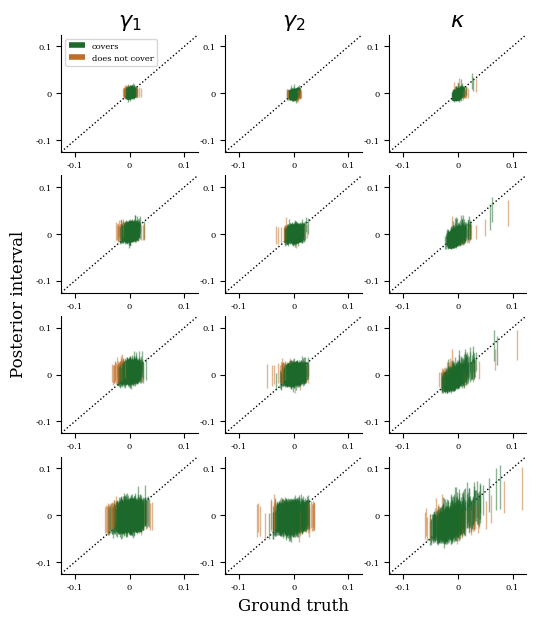

In [9]:
fig, ax = plt.subplots(4, 3, figsize=(6, 7))

fontsize = 12
ticklabelsize = 6
color = np.array(["#c26d27", "#1c692b"])
alpha = 0.5

axmin = -0.125
axmax = 0.125

np.random.seed(0)
indexes = np.random.choice(
    len(test_dl) * 64, 500, replace=False
)  # show credible intervals for 500 randomly selected tiles

interval_idx = 17  # 90% credible interval

for b in range(num_bins):
    _ = ax[b, 0].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1)
    shear1_coverage = (
        (
            shear1_ci_lower[:, :, b, :].flatten(0, 1)
            <= shear1_true[..., b].flatten(0, 1).unsqueeze(-1)
        )
        * (
            shear1_true[..., b].flatten(0, 1).unsqueeze(-1)
            <= shear1_ci_upper[:, :, b, :].flatten(0, 1)
        )
    )[..., interval_idx]

    covered_legend = False
    uncovered_legend = False

    for i in range(len(indexes)):
        if (shear1_coverage[indexes[i]]) and (not covered_legend):
            covered_legend = True
            _ = ax[b, 0].vlines(
                x=shear1_true[..., b].flatten(0, 1)[indexes[i]],
                linewidths=1,
                ymin=shear1_ci_lower[:, :, b, :].flatten(0, 1)[..., interval_idx][indexes[i]],
                ymax=shear1_ci_upper[:, :, b, :].flatten(0, 1)[..., interval_idx][indexes[i]],
                alpha=alpha,
                color=color[shear1_coverage[indexes[i]]],
                label="covers",
            )
        elif (not shear1_coverage[indexes[i]]) and (not uncovered_legend):
            uncovered_legend = True
            _ = ax[b, 0].vlines(
                x=shear1_true[..., b].flatten(0, 1)[indexes[i]],
                linewidths=1,
                ymin=shear1_ci_lower[:, :, b, :].flatten(0, 1)[..., interval_idx][indexes[i]],
                ymax=shear1_ci_upper[:, :, b, :].flatten(0, 1)[..., interval_idx][indexes[i]],
                alpha=alpha,
                color=color[shear1_coverage[indexes[i]]],
                label="does not cover",
            )
        else:
            _ = ax[b, 0].vlines(
                x=shear1_true[..., b].flatten(0, 1)[indexes[i]],
                linewidths=1,
                ymin=shear1_ci_lower[:, :, b, :].flatten(0, 1)[..., interval_idx][indexes[i]],
                ymax=shear1_ci_upper[:, :, b, :].flatten(0, 1)[..., interval_idx][indexes[i]],
                alpha=alpha,
                color=color[shear1_coverage[indexes[i]]],
            )

    _ = ax[b, 1].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1)
    shear2_coverage = (
        (
            shear2_ci_lower[:, :, b, :].flatten(0, 1)
            <= shear2_true[..., b].flatten(0, 1).unsqueeze(-1)
        )
        * (
            shear2_true[..., b].flatten(0, 1).unsqueeze(-1)
            <= shear2_ci_upper[:, :, b, :].flatten(0, 1)
        )
    )[..., interval_idx]

    covered_legend = False
    uncovered_legend = False

    for i in range(len(indexes)):
        if (shear2_coverage[indexes[i]]) and (not covered_legend):
            covered_legend = True
            _ = ax[b, 1].vlines(
                x=shear2_true[..., b].flatten(0, 1)[indexes[i]],
                linewidths=1,
                ymin=shear2_ci_lower[:, :, b, :].flatten(0, 1)[..., interval_idx][indexes[i]],
                ymax=shear2_ci_upper[:, :, b, :].flatten(0, 1)[..., interval_idx][indexes[i]],
                alpha=alpha,
                color=color[shear2_coverage[indexes[i]]],
                label="covers",
            )
        elif (not shear2_coverage[indexes[i]]) and (not uncovered_legend):
            uncovered_legend = True
            _ = ax[b, 1].vlines(
                x=shear2_true[..., b].flatten(0, 1)[indexes[i]],
                linewidths=1,
                ymin=shear2_ci_lower[:, :, b, :].flatten(0, 1)[..., interval_idx][indexes[i]],
                ymax=shear2_ci_upper[:, :, b, :].flatten(0, 1)[..., interval_idx][indexes[i]],
                alpha=alpha,
                color=color[shear2_coverage[indexes[i]]],
                label="does not cover",
            )
        else:
            _ = ax[b, 1].vlines(
                x=shear2_true[..., b].flatten(0, 1)[indexes[i]],
                linewidths=1,
                ymin=shear2_ci_lower[:, :, b, :].flatten(0, 1)[..., interval_idx][indexes[i]],
                ymax=shear2_ci_upper[:, :, b, :].flatten(0, 1)[..., interval_idx][indexes[i]],
                alpha=alpha,
                color=color[shear2_coverage[indexes[i]]],
            )

    _ = ax[b, 2].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1)
    convergence_coverage = (
        (
            convergence_ci_lower[:, :, b, :].flatten(0, 1)
            <= convergence_true[..., b].flatten(0, 1).unsqueeze(-1)
        )
        * (
            convergence_true[..., b].flatten(0, 1).unsqueeze(-1)
            <= convergence_ci_upper[:, :, b, :].flatten(0, 1)
        )
    )[..., interval_idx]

    covered_legend = False
    uncovered_legend = False

    for i in range(len(indexes)):
        if (convergence_coverage[indexes[i]]) and (not covered_legend):
            covered_legend = True
            _ = ax[b, 2].vlines(
                x=convergence_true[..., b].flatten(0, 1)[indexes[i]],
                linewidths=1,
                ymin=convergence_ci_lower[:, :, b, :].flatten(0, 1)[..., interval_idx][indexes[i]],
                ymax=convergence_ci_upper[:, :, b, :].flatten(0, 1)[..., interval_idx][indexes[i]],
                alpha=alpha,
                color=color[convergence_coverage[indexes[i]]],
                label="covers",
            )
        elif (not convergence_coverage[indexes[i]]) and (not uncovered_legend):
            uncovered_legend = True
            _ = ax[b, 2].vlines(
                x=convergence_true[..., b].flatten(0, 1)[indexes[i]],
                linewidths=1,
                ymin=convergence_ci_lower[:, :, b, :].flatten(0, 1)[..., interval_idx][indexes[i]],
                ymax=convergence_ci_upper[:, :, b, :].flatten(0, 1)[..., interval_idx][indexes[i]],
                alpha=alpha,
                color=color[convergence_coverage[indexes[i]]],
                label="does not cover",
            )
        else:
            _ = ax[b, 2].vlines(
                x=convergence_true[..., b].flatten(0, 1)[indexes[i]],
                linewidths=1,
                ymin=convergence_ci_lower[:, :, b, :].flatten(0, 1)[..., interval_idx][indexes[i]],
                ymax=convergence_ci_upper[:, :, b, :].flatten(0, 1)[..., interval_idx][indexes[i]],
                alpha=alpha,
                color=color[convergence_coverage[indexes[i]]],
            )

leg = ax[0, 0].legend(loc="upper left", prop={"size": ticklabelsize})
for lh in leg.legend_handles:
    lh.set_alpha(1)
for line in leg.get_lines():
    line.set_linewidth(4)
_ = ax[0, 0].set_title(r"$\gamma_1$", fontsize=16)
_ = ax[0, 1].set_title(r"$\gamma_2$", fontsize=16)
_ = ax[0, 2].set_title(r"$\kappa$", fontsize=16)
_ = ax[3, 1].set_xlabel("Ground truth", fontsize=fontsize)
_ = ax[1, 0].set_ylabel("Posterior interval", fontsize=fontsize)
_ = ax[1, 0].yaxis.set_label_coords(-0.25, -0.1)

for a in ax.flat:
    _ = a.spines[["top", "right"]].set_visible(False)
    _ = a.set_xlim(axmin, axmax)
    _ = a.set_ylim(axmin, axmax)
    _ = a.set_xticks([-0.1, 0, 0.1], [-0.1, 0, 0.1])
    _ = a.set_yticks([-0.1, 0, 0.1], [-0.1, 0, 0.1])
    _ = a.tick_params(axis="both", which="major", labelsize=ticklabelsize)

fig.savefig(
    "figures/credibleintervals.png", dpi=600, transparent=True, bbox_inches="tight", pad_inches=0
)

**Plot nominal vs. empirical coverage:**

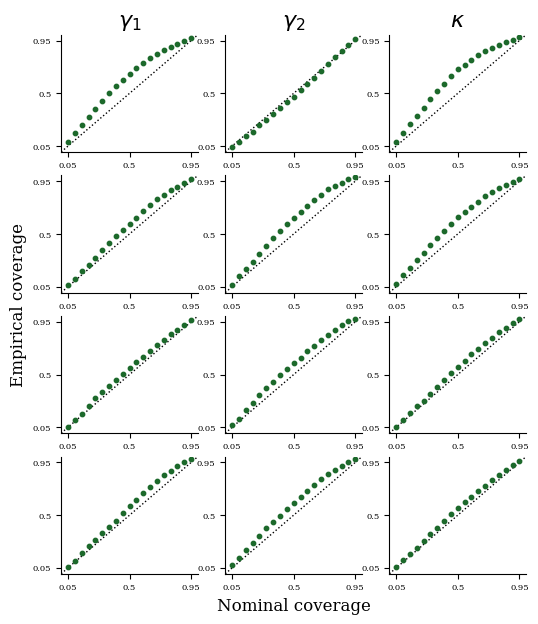

In [10]:
fig, ax = plt.subplots(4, 3, figsize=(6, 7))

fontsize = 12
ticklabelsize = 6
marker_color = "#1c692b"
alpha = 0.5
s = 10

for b in range(num_bins):
    _ = ax[b, 0].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1, zorder=0)
    _ = ax[b, 0].scatter(
        confidence_levels, shear1_coverage_probs[b], color=marker_color, s=s, zorder=1
    )

    _ = ax[b, 1].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1, zorder=0)
    _ = ax[b, 1].scatter(
        confidence_levels, shear2_coverage_probs[b], color=marker_color, s=s, zorder=1
    )

    _ = ax[b, 2].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1, zorder=0)
    _ = ax[b, 2].scatter(
        confidence_levels, convergence_coverage_probs[b], color=marker_color, s=s, zorder=1
    )

_ = ax[0, 0].set_title(r"$\gamma_1$", fontsize=16)
_ = ax[0, 1].set_title(r"$\gamma_2$", fontsize=16)
_ = ax[0, 2].set_title(r"$\kappa$", fontsize=16)
_ = ax[3, 1].set_xlabel("Nominal coverage", fontsize=fontsize)
_ = ax[1, 0].set_ylabel("Empirical coverage", fontsize=fontsize)
_ = ax[1, 0].yaxis.set_label_coords(-0.25, -0.1)

for a in ax.flat:
    _ = a.spines[["top", "right"]].set_visible(False)
    _ = a.set_xlim(0, 1)
    _ = a.set_ylim(0, 1)
    _ = a.set_xticks([0.05, 0.5, 0.95], [0.05, 0.5, 0.95])
    _ = a.set_yticks([0.05, 0.5, 0.95], [0.05, 0.5, 0.95])
    _ = a.tick_params(axis="both", which="major", labelsize=ticklabelsize)

fig.savefig(
    "figures/coverageprobs.png", dpi=600, transparent=True, bbox_inches="tight", pad_inches=0
)